# Exploratory Data Analysis on Merged Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.express as px

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [3]:
# Load the final merged dataset
df_final = pd.read_csv("../data/processed/restaurants_data_merged_final.csv")
print("Shape:", df_final.shape)
print("Columns:", df_final.columns.tolist())
df_final.head()


Shape: (4598, 8)
Columns: ['name', 'price', 'rating', 'review_count', 'cuisine', 'address', 'display_phone', 'comments']


,name,price,rating,review_count,cuisine,address,display_phone,comments
0,123 Burger Shot Beer,1,3.0,1000.0,"['american', 'sportsbars', 'tradamerican', 'ch...","738 10th Ave, Hells Kitchen, NY 10019",(212) 315-0123,NaN
1,One Stop Patty Shop,1,4.0,40.0,"['bakery', 'caribbean', 'breakfast_brunch']","1708 Amsterdam Ave, Harlem, NY 10031",(212) 491-7466,NaN
2,108 Food Dried Hot Pot,2,3.5,139.0,"['chinese', 'hotpot']","2794 Broadway, East Harlem, NY 10025",(917) 675-6878,NaN
3,Cookshop,2,4.0,1000.0,"['american', 'newamerican', 'breakfast_brunch'...","156 10th Ave, Midtown West, NY 10011",(212) 924-4440,NaN
4,11 Hanover Greek,3,4.0,122.0,"['greek', 'seafood', 'wine_bars']","11 Hanover Sq, Tribeca, NY 10005",(212) 785-4000,NaN


In [4]:
# Rename price to price_level and comments to reviews
df_final.rename(columns={'price': 'price_level', 'comments': 'reviews'}, inplace=True)

In [5]:
# Get all rows with non-null reviews
df_comments = df_final[df_final['reviews'].notna()]
print(f"restaurants with reviews: {len(df_comments)}")
df_comments.head()

restaurants with reviews: 522


,name,price_level,rating,review_count,cuisine,address,display_phone,reviews
3728,Table Talk Diner,2,4.0,256.0,"['american', 'diner', 'vegetarian_friendly']","2521 South Rd Ste C, Poughkeepsie, NY 12601-5476",+1 845-849-2839,Waitress was very friendly but a little pricey...
3729,The Clam Bar,2,4.0,285.0,"['american', 'bar', 'seafood']","3914 Brewerton Rd, Syracuse, NY 13212",+1 315-458-1662,Doesn't look like much from the outside but wa...
3730,John Thomas Steakhouse,2,4.0,258.0,"['american', 'steakhouse', 'gluten_free_options']","1152 Danby Rd, Ithaca, NY 14850-8927",+1 607-273-3464,"The ambience, food and service were all excell..."
3731,ZaZa's Cucina,2,4.0,271.0,"['italian', 'vegetarian_friendly', 'gluten_fre...","622 Cascadilla St, Ithaca, NY 14850-4049",+1 607-273-9292,"Nice big dining area. Holds many people, so n..."
3732,New World Bistro Bar,2,4.5,706.0,"['american', 'bar', 'vegetarian_friendly']","300 Delaware Ave, Albany, NY 12209-1627",+1 518-694-0520,"Came with a group of eight people, and had a w..."


In [6]:
# Check for duplicates
duplicates = df_final[df_final.duplicated(subset=['name', 'address'], keep=False)]
print(f"Number of duplicate rows: {len(duplicates)}")
duplicates.head()

Number of duplicate rows: 0


,name,price_level,rating,review_count,cuisine,address,display_phone,reviews


In [7]:
df_final.info()

<class 'pandas.DataFrame'>
RangeIndex: 4598 entries, 0 to 4597
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           4598 non-null   str    
 1   price_level    4598 non-null   int64  
 2   rating         4598 non-null   float64
 3   review_count   4598 non-null   float64
 4   cuisine        4598 non-null   str    
 5   address        4598 non-null   str    
 6   display_phone  4250 non-null   str    
 7   reviews        522 non-null    str    
dtypes: float64(2), int64(1), str(5)
memory usage: 287.5 KB


## Price Level Analysis

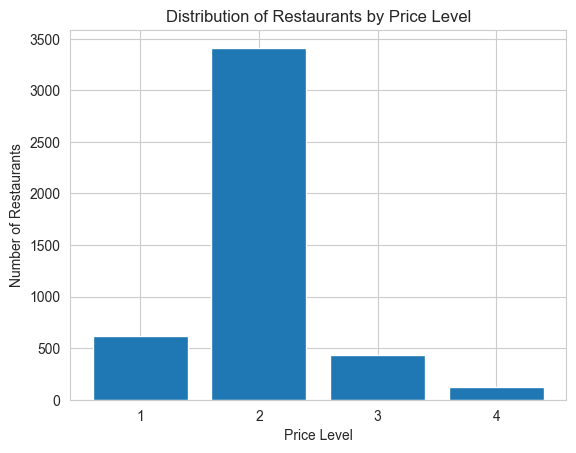

In [8]:
# Bar graph with price level on x-axis and count of restaurants on y-axis
price_counts = df_final['price_level'].value_counts().sort_index()
plt.bar(price_counts.index, price_counts.values)
plt.xlabel('Price Level')
plt.ylabel('Number of Restaurants')
plt.title('Distribution of Restaurants by Price Level')
plt.xticks(price_counts.index)
plt.show()

The majority of NYC restaurants in the dataset are in the 2nd price level ($$).

In [19]:
# Price level vs average rating
df_final.groupby('price_level')['rating'].mean()

price_level
1    3.648148
2    4.006885
3    3.885845
4    4.055556
Name: rating, dtype: float64

## Cuisine Analysis

In [9]:
import ast

# Ensure cuisine column is a proper list (if stored as string)
df_final["cuisine"] = df_final["cuisine"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Explode so each cuisine is its own row
df_cuisine = df_final.explode("cuisine")

# Ensure cuisine values are plain strings
df_cuisine["cuisine"] = df_cuisine["cuisine"].astype(str)

# Group and compute stats
cuisine_stats = (
    df_cuisine
        .groupby("cuisine", as_index=False)
        .agg(
            count=("name", "count"),
            avg_rating=("rating", "mean"),
            avg_price_level=("price_level", "mean"),
            num_reviews=("review_count", "sum") 
        )
        .sort_values("count", ascending=False)
        .head(10)
)

cuisine_stats.reset_index(drop=True, inplace=True)
print(cuisine_stats)

               cuisine  count  avg_rating  avg_price_level  num_reviews
0             american   1125    3.943111         2.072889     446164.0
1              italian    734    4.039510         2.148501     333280.0
2          newamerican    372    3.881720         2.309140     154833.0
3              chinese    362    3.730663         1.734807      99108.0
4                pizza    347    3.883285         1.668588     101106.0
5             japanese    341    3.994135         2.284457     130435.0
6     breakfast_brunch    336    3.875000         2.002976     151489.0
7         tradamerican    290    3.662069         2.089655     112721.0
8                 bars    285    3.831579         2.210526     122981.0
9  vegetarian_friendly    269    4.377323         2.000000      69957.0


In [ ]:
# Get cuisine with highest avg_rating
top = cuisine_stats.sort_values(
    ['avg_rating', 'avg_price_level', 'num_reviews'],
    ascending=False
).head(1)

print(top[['cuisine', 'avg_rating', 'avg_price_level', 'num_reviews']].to_string(index=False))

            cuisine  avg_rating  avg_price_level  num_reviews
vegetarian_friendly    4.377323              2.0      69957.0


In [23]:
# Get cuisine with highest avg_price_level
highest_price_cuisine = cuisine_stats.nlargest(1, 'avg_price_level')
print("Cuisine with Highest Average Price Level:")
print(highest_price_cuisine[['cuisine', 'avg_price_level', 'count', 'avg_rating']])


Cuisine with Highest Average Price Level:
       cuisine  avg_price_level  count  avg_rating
2  newamerican          2.30914    372     3.88172


               cuisine  avg_price_level  count  avg_rating
2          newamerican         2.309140    372    3.881720
5             japanese         2.284457    341    3.994135
8                 bars         2.210526    285    3.831579
1              italian         2.148501    734    4.039510
7         tradamerican         2.089655    290    3.662069
0             american         2.072889   1125    3.943111
6     breakfast_brunch         2.002976    336    3.875000
9  vegetarian_friendly         2.000000    269    4.377323
3              chinese         1.734807    362    3.730663
4                pizza         1.668588    347    3.883285


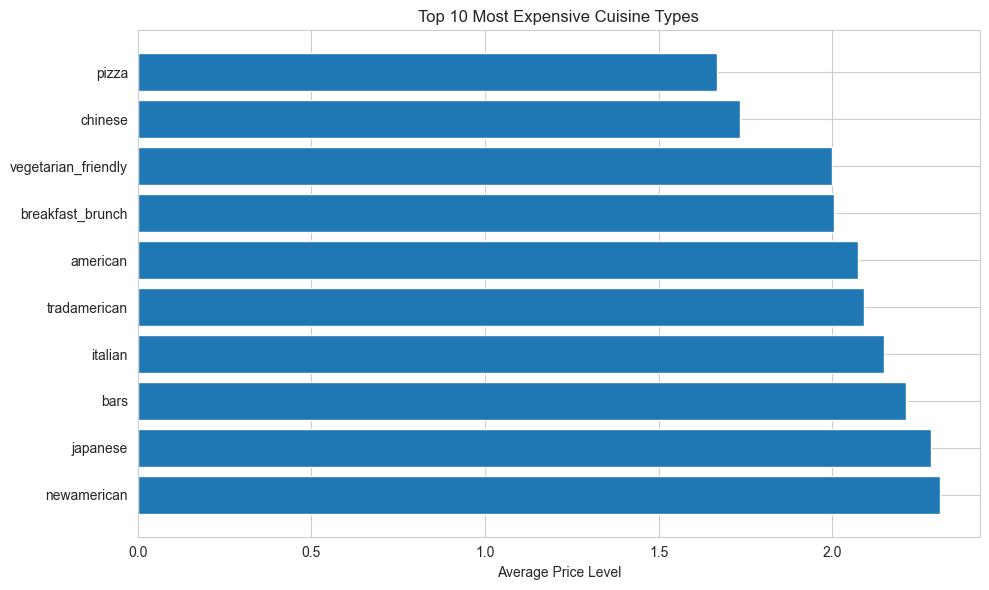

In [10]:
# Find the most expensive cuisine types by average price level
most_expensive_cuisine = cuisine_stats.nlargest(10, 'avg_price_level')[['cuisine', 'avg_price_level', 'count', 'avg_rating']]
print(most_expensive_cuisine)

plt.figure(figsize=(10, 6))
plt.barh(most_expensive_cuisine['cuisine'], most_expensive_cuisine['avg_price_level'])
plt.xlabel('Average Price Level')
plt.title('Top 10 Most Expensive Cuisine Types')
plt.tight_layout()
plt.show()

## Rating Analysis

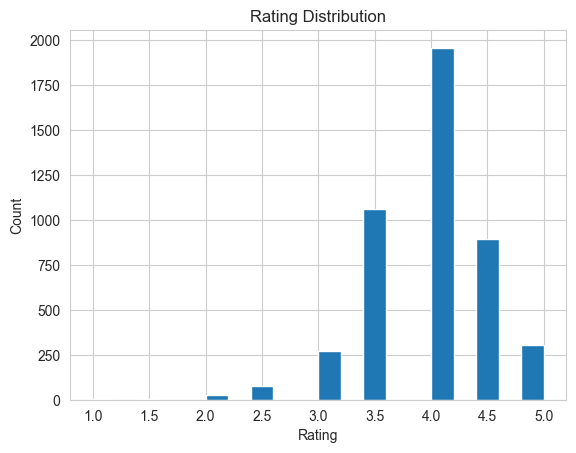

In [11]:
# Rating distribution histogram
plt.figure()
plt.hist(df_final['rating'], bins=20)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [12]:
# Calculate weighted rating using the formula: (v/(v+m) * R) + (m/(v+m) * C)
C = df_final['rating'].mean()
m = df_final['review_count'].quantile(0.75)

df_final['weighted_rating'] = (
    (df_final['review_count'] / (df_final['review_count'] + m)) * df_final['rating']
    + (m / (df_final['review_count'] + m)) * C
)

df_final[['name','rating','review_count','weighted_rating']].head()

,name,rating,review_count,weighted_rating
0,123 Burger Shot Beer,3.0,1000.0,3.328880
1,One Stop Patty Shop,4.0,40.0,3.951864
2,108 Food Dried Hot Pot,3.5,139.0,3.855246
3,Cookshop,4.0,1000.0,3.982047
4,11 Hanover Greek,4.0,122.0,3.957909


## Geographic Analysis

Restaurants by Neighborhood/borough:
neighborhood/borough
Midtown          903
Harlem           577
New York City     65
Tribeca           36
Ithaca            31
Staten Island     31
Poughkeepsie      30
Saratoga          29
Schenectady       29
Buffalo           29
Syracuse          28
Albany            27
Brooklyn          22
Bronx             12
Hells Kitchen     11
Queens             2
Manhattan          1
Name: count, dtype: int64

Neighborhood/Borough Statistics:
                      avg_rating  avg_price_level  avg_review_count  \
neighborhood/borough                                                  
Midtown                     3.98             2.23            474.80   
Harlem                      3.84             1.84            234.66   
New York City               4.46             2.00            376.18   
Tribeca                     3.71             2.06            306.89   
Ithaca                      4.23             2.00            280.84   
Staten Island               

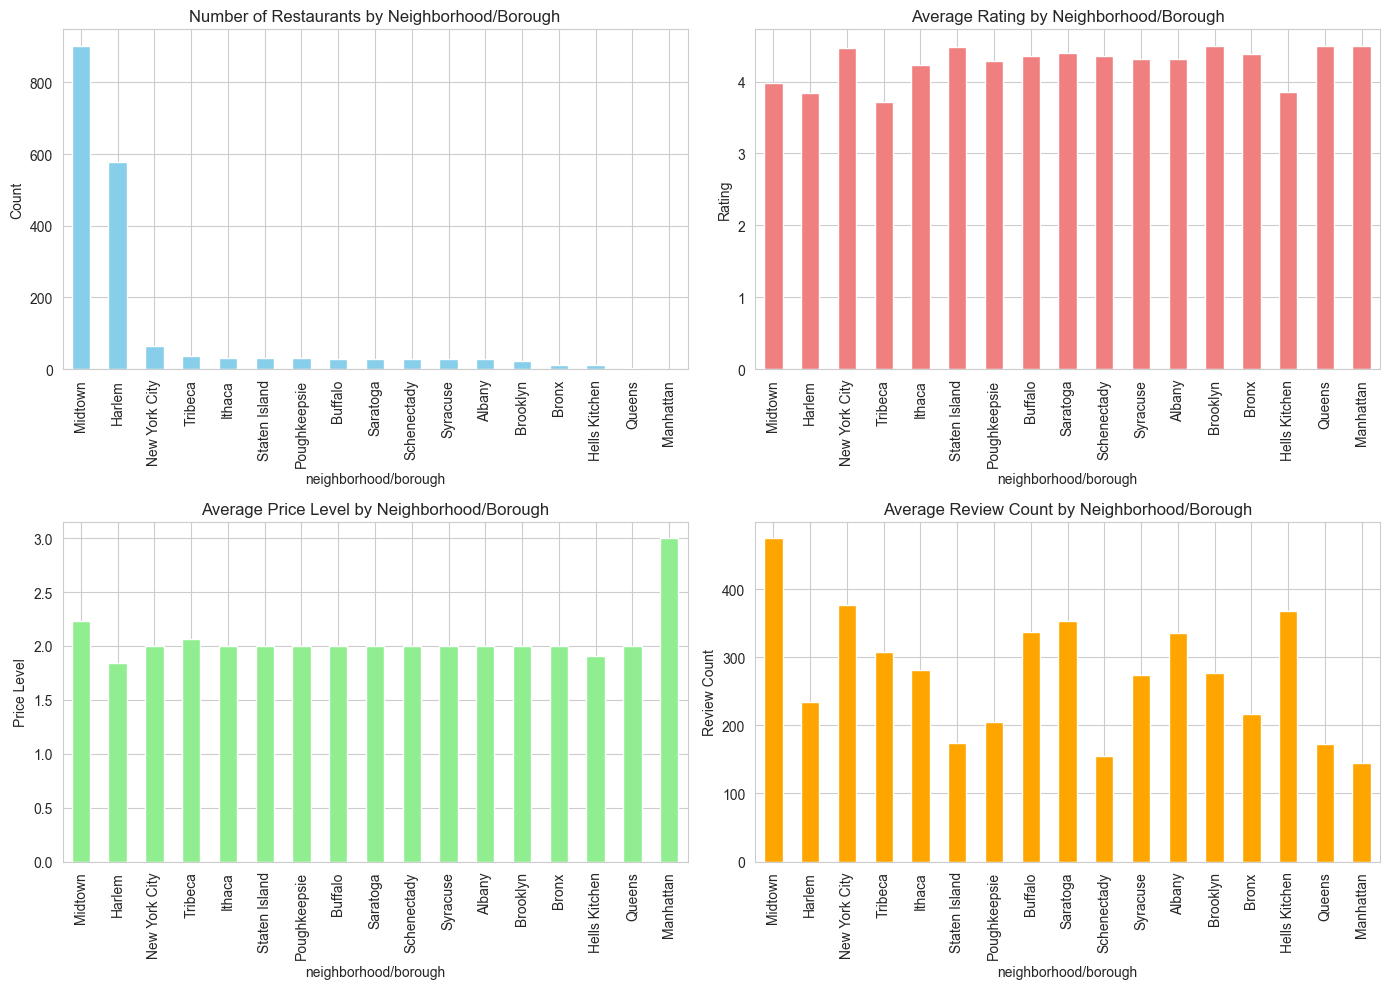

In [14]:
# Extract neighborhood/borough from address
df_final['neighborhood/borough'] = df_final['address'].str.extract(r'(New York City|Brooklyn|Queens|Bronx|Staten Island|Harlem|Midtown|Tribeca|Hells Kitchen|Manhattan|Upstate|Poughkeepsie|Syracuse|Ithaca|Albany|Buffalo|Saratoga|Schenectady)')

# Count restaurants by borough
borough_counts = df_final['neighborhood/borough'].value_counts()
print("Restaurants by Neighborhood/borough:")
print(borough_counts)

# Average rating by borough
borough_stats = df_final.groupby('neighborhood/borough').agg({
    'rating': 'mean',
    'price_level': 'mean',
    'review_count': 'mean',
    'name': 'count'
}).round(2)
borough_stats.columns = ['avg_rating', 'avg_price_level', 'avg_review_count', 'restaurant_count']
borough_stats = borough_stats.sort_values('restaurant_count', ascending=False)
print("\nNeighborhood/Borough Statistics:")
print(borough_stats)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

borough_stats['restaurant_count'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Number of Restaurants by Neighborhood/Borough')
axes[0, 0].set_ylabel('Count')

borough_stats['avg_rating'].plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Average Rating by Neighborhood/Borough')
axes[0, 1].set_ylabel('Rating')

borough_stats['avg_price_level'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Average Price Level by Neighborhood/Borough')
axes[1, 0].set_ylabel('Price Level')

borough_stats['avg_review_count'].plot(kind='bar', ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Average Review Count by Neighborhood/Borough')
axes[1, 1].set_ylabel('Review Count')

plt.tight_layout()
plt.show()

## Text & Review Analysis

| Score | Meaning       |
| ----- | ------------- |
| -1    | Very negative |
| 0     | Neutral       |
| +1    | Very positive |


Sentiment Statistics:
count    522.000000
mean       0.301885
std        0.265977
min       -0.800000
25%        0.136768
50%        0.320505
75%        0.492679
max        1.000000
Name: sentiment, dtype: float64


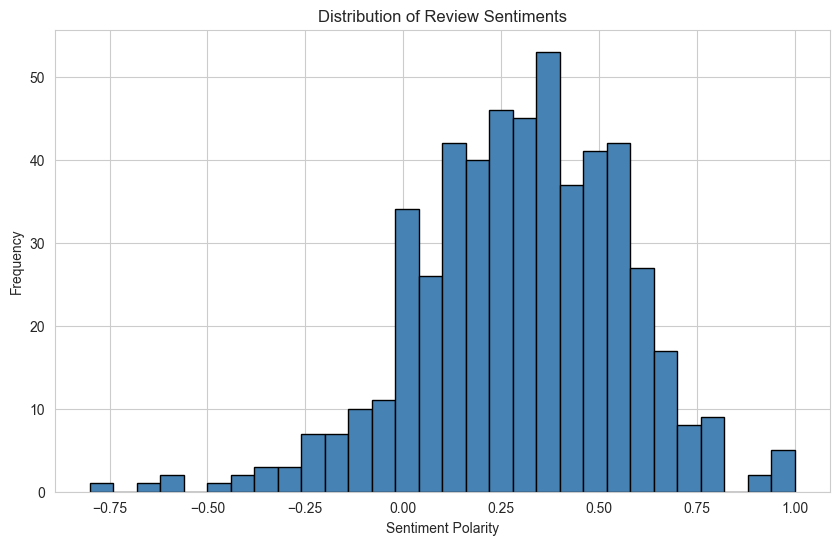

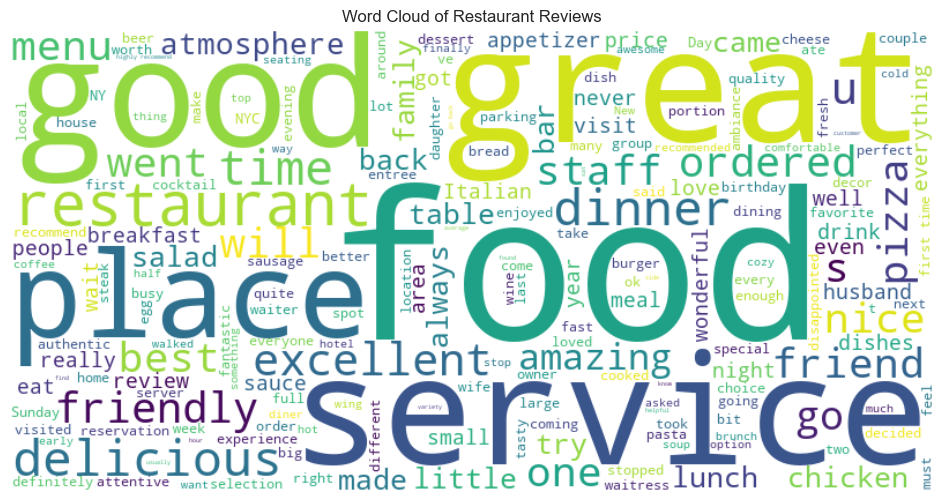

In [15]:
from textblob import TextBlob
from wordcloud import WordCloud

# Filter out null reviews
df_reviews = df_final[df_final['reviews'].notna()].copy()

# Sentiment analysis on reviews
df_reviews['sentiment'] = df_reviews['reviews'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

print("Sentiment Statistics:")
print(df_reviews['sentiment'].describe())

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
plt.hist(df_reviews['sentiment'], bins=30, color='steelblue', edgecolor='black')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Review Sentiments')
plt.show()

# Generate word cloud from all reviews
all_reviews_text = ' '.join(df_reviews['reviews'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Restaurant Reviews')
plt.show()

Top 10 Cuisines with Most Positive Reviews:
                     positive_review_count  avg_sentiment  avg_rating
cuisine                                                              
vegetarian_friendly                    226       0.375290    4.382743
american                               216       0.359414    4.317130
italian                                129       0.389010    4.368217
bar                                     91       0.341970    4.263736
vegan_options                           61       0.391649    4.426230
pizza                                   53       0.402023    4.349057
gluten_free_options                     49       0.335654    4.357143
asian                                   44       0.350971    4.363636
pub                                     42       0.354617    4.309524
seafood                                 35       0.337922    4.300000


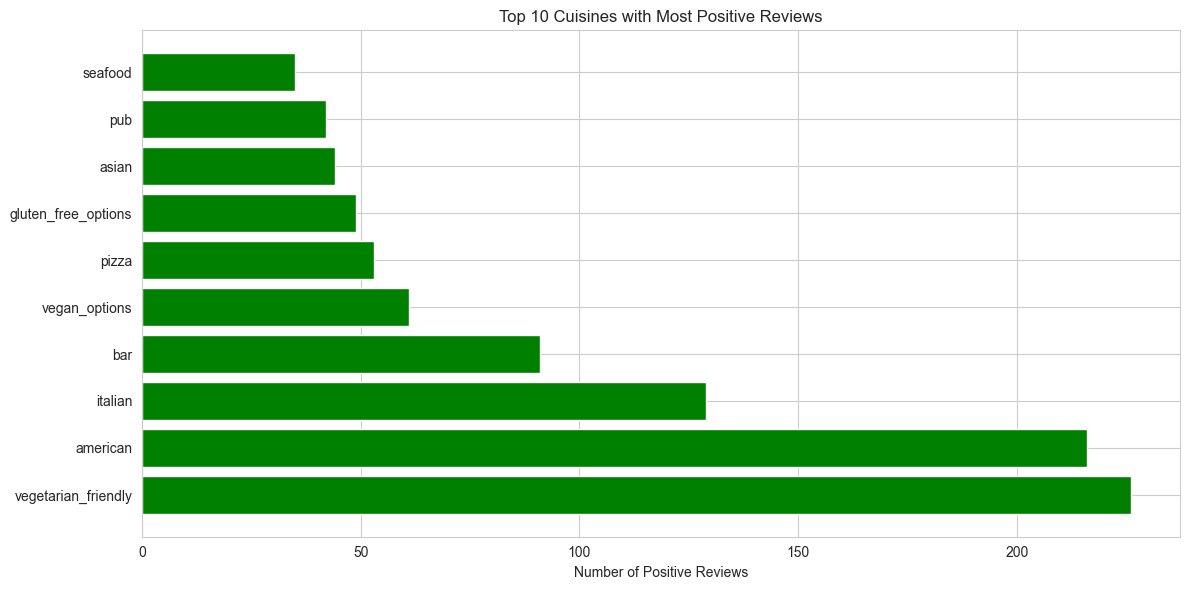

In [16]:
# Find cuisines with most positive reviews
positive_reviews = df_reviews[df_reviews['sentiment'] > 0].copy()
cuisine_sentiment = (
    positive_reviews.explode('cuisine')
    .groupby('cuisine')
    .agg(
        positive_review_count=('sentiment', 'count'),
        avg_sentiment=('sentiment', 'mean'),
        avg_rating=('rating', 'mean')
    )
    .sort_values('positive_review_count', ascending=False)
    .head(10)
)

print("Top 10 Cuisines with Most Positive Reviews:")
print(cuisine_sentiment)

# Visualization
plt.figure(figsize=(12, 6))
plt.barh(cuisine_sentiment.index, cuisine_sentiment['positive_review_count'], color='green')
plt.xlabel('Number of Positive Reviews')
plt.title('Top 10 Cuisines with Most Positive Reviews')
plt.tight_layout()
plt.show()

Top 10 Cuisines with Most Negative Reviews:
                     negative_review_count  avg_sentiment  avg_rating
cuisine                                                              
vegetarian_friendly                     33      -0.197498    4.348485
american                                25      -0.212344    4.180000
italian                                 13      -0.124651    4.423077
vegan_options                           11      -0.168513    4.318182
bar                                      8      -0.172361    4.125000
gluten_free_options                      7      -0.183155    4.214286
pub                                      6      -0.191898    4.166667
pizza                                    4      -0.067783    4.375000
asian                                    3      -0.234815    4.166667
steakhouse                               3      -0.139444    4.000000


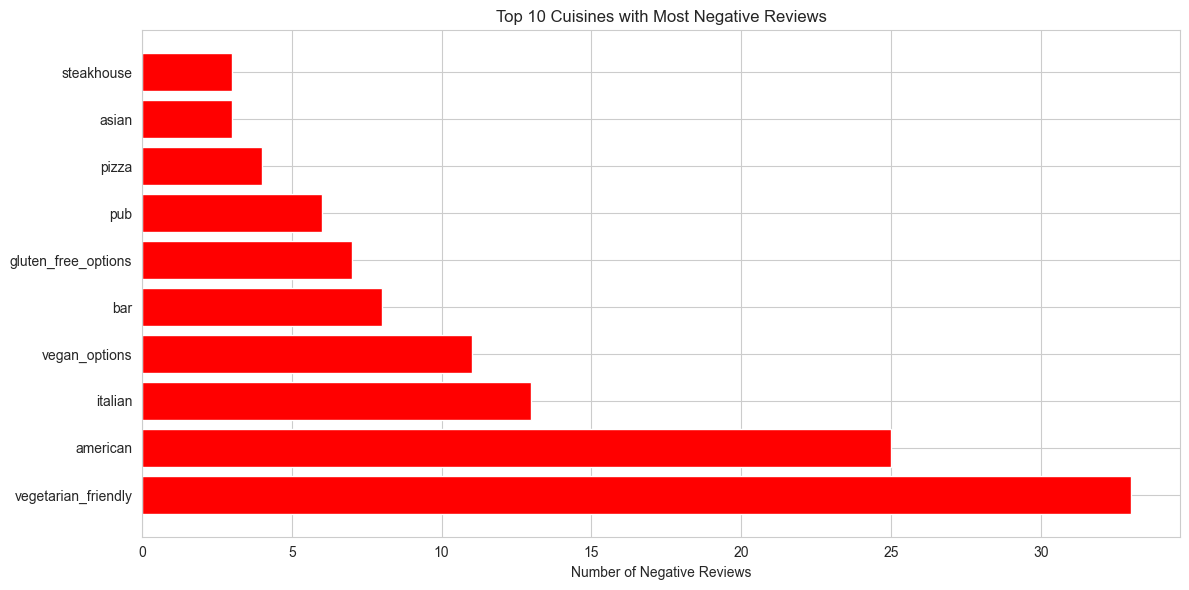

In [17]:
# Find cuisines with most negative reviews
negative_reviews = df_reviews[df_reviews['sentiment'] < 0].copy()
cuisine_negative = (
    negative_reviews.explode('cuisine')
    .groupby('cuisine')
    .agg(
        negative_review_count=('sentiment', 'count'),
        avg_sentiment=('sentiment', 'mean'),
        avg_rating=('rating', 'mean')
    )
    .sort_values('negative_review_count', ascending=False)
    .head(10)
)

print("Top 10 Cuisines with Most Negative Reviews:")
print(cuisine_negative)

# Visualization
plt.figure(figsize=(12, 6))
plt.barh(cuisine_negative.index, cuisine_negative['negative_review_count'], color='red')
plt.xlabel('Number of Negative Reviews')
plt.title('Top 10 Cuisines with Most Negative Reviews')
plt.tight_layout()
plt.show()